In [1]:
# Add all necessary imports here
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy.sparse
np.set_printoptions(precision=3, suppress=True)
%matplotlib inline
plt.style.reload_library()
plt.style.use("ggplot")

/Users/jaroslaw.szymczak/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Cover Slide 1

### Divider

![Color](img/roadmap_tree.png)

# Classification problem example

![Color](img/play_tennis_table.png)

# Example decision tree

![Color](img/play_tennis_tree.png)

![Color](img/roadmap_bias_variance.png)

# Bias and variance source of error

![Color](img/bias_variance.png)

![Color](img/roadmap_bagging.png)

# Bagging
![Color](img/bagging.png)

![Color](img/roadmap_random_forest.png)

![Color](img/random_forest.png)

![Color](img/roadmap_adaboost.png)

# Adaptive Boosting

![Color](img/adaboost.png)

![Color](img/roadmap_gbm.png)

#  Gradient Boosting

![Color](img/gbm_regression.png)

# Gradient descent
![Color](img/gbm_gradient.png)

![Color](img/roadmap_xgb.png)

# XGBoost

![Color](img/xgb_features_1.png)

# XGBoost custom tree building algorithm

Most of machine learning practitioners know at least these two measures used for tree building:
- entropy (information gain)
- gini coefficient

XGBoost has a custom objective function used for building the tree. It requires:
- gradient
- hessian

of the objective function. E.g. for linear regression and RMSE, for single observation:
- gradient = residual
- hessian = 1

We will go further into regularization parameters when we discuss tree tuning.

# XGBoost

![Color](img/xgb_features_2.png)

# XGBoost classifier with default parameters

In [2]:
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.__dict__

{'_Booster': None,
 'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [3]:
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X, y = train.data, train.target
#X = np.array(X)
#y = np.array(y)
#train_selection = (np.random.random(size=X.shape[0]) < 0.05)
#X = X[train_selection]
#y = y[train_selection]
X_test_docs, y_test = test.data, test.target
X_train_docs, X_val_docs, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.5).fit(X_train_docs)
X_train_tfidf = tfidf.transform(X_train_docs).tocsc()
X_val_tfidf = tfidf.transform(X_val_docs).tocsc()
X_test_tfidf = tfidf.transform(X_test_docs).tocsc()

# Dataset preparation
```python
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
X, y = train.data, train.target
X_test_docs, y_test = test.data, test.target
X_train_docs, X_val_docs, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.5).fit(X_train)
X_train_tfidf = tfidf.transform(X_train_docs).tocsc()
X_val_tfidf = tfidf.transform(X_val_docs).tocsc()
X_test_tfidf = tfidf.transform(X_test_docs).tocsc()
```

In [70]:
print("X_train shape: {}".format(X_train_tfidf.get_shape()))
print("X_val shape: {}".format(X_val_tfidf.get_shape()))
print("X_test shape: {}".format(X_test_tfidf.get_shape()))
print("X_train density: {:.3f}".format(
    (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape))))

X_train shape: (9051, 2665)
X_val shape: (2263, 2665)
X_test shape: (7532, 2665)
X_train density: 0.023


# Simple classification

In [5]:
clf = xgb.XGBClassifier(seed=42, nthread=1)
clf = clf.fit(X_train_tfidf, y_train, 
              eval_set=[(X_train_tfidf, y_train), (X_val_tfidf, y_val)], 
              verbose=11)

y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)
print("Test error: {:.3f}".format(1 - accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.588443	validation_1-merror:0.600088
[11]	validation_0-merror:0.429345	validation_1-merror:0.476359
[22]	validation_0-merror:0.390012	validation_1-merror:0.454264
[33]	validation_0-merror:0.356093	validation_1-merror:0.443659
[44]	validation_0-merror:0.330461	validation_1-merror:0.433053
[55]	validation_0-merror:0.308806	validation_1-merror:0.427309
[66]	validation_0-merror:0.28936	validation_1-merror:0.423774
[77]	validation_0-merror:0.270909	validation_1-merror:0.41361
[88]	validation_0-merror:0.256988	validation_1-merror:0.410517
[99]	validation_0-merror:0.242404	validation_1-merror:0.410517
Test error: 0.462


# Exploring some XGBoost properties

As mentioned in meetup description, we will see that:

- monotonic transformation have little to no effect on final results

- features can be correlated

- classifier is robust to noise

# Repeating the process without IDF factor

In [6]:
tf = TfidfVectorizer(min_df=0.005, max_df=0.5, use_idf=False).fit(X_train_docs)
X_train = tf.transform(X_train_docs).tocsc()
X_val = tf.transform(X_val_docs).tocsc()
X_test = tf.transform(X_test_docs).tocsc()

clf = xgb.XGBClassifier(seed=42, nthread=1).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=33)

y_pred = clf.predict(X_test)
print("Test error: {:.3f}".format(1 - accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.588443	validation_1-merror:0.604507
[33]	validation_0-merror:0.356093	validation_1-merror:0.443659
[66]	validation_0-merror:0.288034	validation_1-merror:0.419355
[99]	validation_0-merror:0.241962	validation_1-merror:0.411843
Test error: 0.461


Previous run:
```
[0]     validation_0-merror:0.588443	validation_1-merror:0.600088
[33]	validation_0-merror:0.356093	validation_1-merror:0.443659
[66]	validation_0-merror:0.28936	 validation_1-merror:0.423774
[99]	validation_0-merror:0.242404	validation_1-merror:0.410517
```

# Adding some correlated CountVectorizer features

In [7]:
cv = CountVectorizer(min_df=0.005, max_df=0.5).fit(X_train_docs)

X_train_cv = cv.transform(X_train_docs).tocsc()
X_val_cv = cv.transform(X_val_docs).tocsc()
X_test_cv = cv.transform(X_test_docs).tocsc()

X_train_corr = scipy.sparse.hstack([X_train, X_train_cv])
X_val_corr = scipy.sparse.hstack([X_val, X_val_cv])
X_test_corr = scipy.sparse.hstack([X_test, X_test_cv])

clf = xgb.XGBClassifier(seed=42, nthread=1)
clf = clf.fit(X_train_corr, y_train, eval_set=[(X_train_corr, y_train), (X_val_corr, y_val)], verbose=99)

y_pred = clf.predict(X_test_corr)
print("Test error: {:.3f}".format(1 - accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.588664	validation_1-merror:0.60274
[99]	validation_0-merror:0.240636	validation_1-merror:0.408308
Test error: 0.464


# Adding some randomness

In [8]:
def extend_with_random(X, density=0.023):
    X_extend = scipy.sparse.random(X.shape[0], 2*X.shape[1], density=density, format='csc')
    return scipy.sparse.hstack([X, X_extend])


X_train_noise = extend_with_random(X_train)
X_val_noise = extend_with_random(X_val)
X_test_noise = extend_with_random(X_test)

clf = xgb.XGBClassifier(seed=42, nthread=1)
clf = clf.fit(X_train_noise, y_train, eval_set=[(X_train_noise, y_train), (X_val_noise, y_val)], verbose=99)

y_pred = clf.predict(X_test_noise)
print("Test error: {:.3f}".format(1 - accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.588443	validation_1-merror:0.604507
[99]	validation_0-merror:0.221522	validation_1-merror:0.417587
Test error: 0.470


# Some XGBoost features


- watchlists (that we have seen so far)

- early stopping

- full learning history that we can plot

# Early stopping with watchlist

In [9]:
clf = xgb.XGBClassifier(n_estimators=50000)
clf = clf.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_val, y_val)], 
              verbose=100, 
              early_stopping_rounds=10)

print("Best iteration: {}".format(clf.booster().best_iteration))
y_pred = clf.predict(X_test, ntree_limit=clf.booster().best_ntree_limit)
print("Test error: {:.3f}".format(1 - accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.588443	validation_1-merror:0.604507
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[100]	validation_0-merror:0.241189	validation_1-merror:0.412285
Stopping. Best iteration:
[123]	validation_0-merror:0.215114	validation_1-merror:0.401679

Best iteration: 123
Test error: 0.457


# Plotting the learning curves

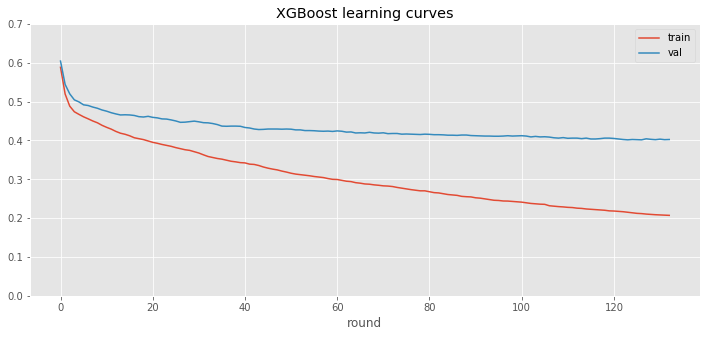

In [10]:
evals_result = clf.evals_result()
train_errors = evals_result['validation_0']['merror']
validation_errors = evals_result['validation_1']['merror']
df = pd.DataFrame([train_errors, validation_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title="XGBoost learning curves", ylim=(0,0.7), figsize=(12,5))

# Tuning setting

- we will do the comparison of errors on train, validation and test sets
- normally I would recommend cross-validation for such task
- together with a hold-out set that you check rarely
- as you can overfit even when you use cross-validation
- slight changes in error are inconclusive about parameters, just try different random seeds and you'll see for yourself
- some parameters affect the training time, so it is enough that they don't make the final model worse, they don't have to improve it

# General parameters

- max_depth (how deep is your tree?)

- learning_rate (shrinkage parameter, "speed of learning")

- max_delta_step (additional cap on learning rate, needed in case of highly imbalanced classes, in which case it is suggested to try values from 1 to 10)

- n_estimators (number of boosting rounds)

- booster (as XGBoost is not only about trees, but it actually is)

- scale_pos_weight (in binary classification whether to rebalance the weights of positive vs. negative samples)

- base_score (boosting starts with predicting 0.5 for all observations, you can change it here)

- seed / random_state (so you can reproduce your results, will not work exactly if you use multiple threads or on some processor / system architectures due to randomness introduced by floating point numbers rounding)

- missing (if you want to treat some other things as missing than np.nan)

- objective (if you want to play with maths, just give the callable that maps objective(y_true, y_pred) -> grad, hes)

Normally you will not really tune this parameters, apart from max_depth (and potentially learning_rate, but with so many others to tune I suggest to settle for sensible value). You can modify them, e.g. learning rate, if you think it makes sense, but you would rather not use hyperopt / sklearn grid search to find the optimal values here.

# Effect of max_depth error characteristics

In [31]:
results = []

for max_depth in [3, 6, 9, 12, 15, 30]:
    clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=20)
    clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': 1 - accuracy_score(y_train, clf.predict(X_train)),
            'validation_error': 1 - accuracy_score(y_val, clf.predict(X_val)),
            'test_error': 1 - accuracy_score(y_test, clf.predict(X_test))
        }
    )
    

In [32]:
df_max_depth = pd.DataFrame(results).set_index('max_depth').sort_index()
df_max_depth

,test_error,train_error,validation_error
max_depth,,,
3,0.504647,0.398630,0.462218
6,0.489379,0.292785,0.444101
9,0.492167,0.219755,0.443217
12,0.495884,0.169263,0.441008
15,0.492698,0.134350,0.437914
30,0.492432,0.064192,0.439682


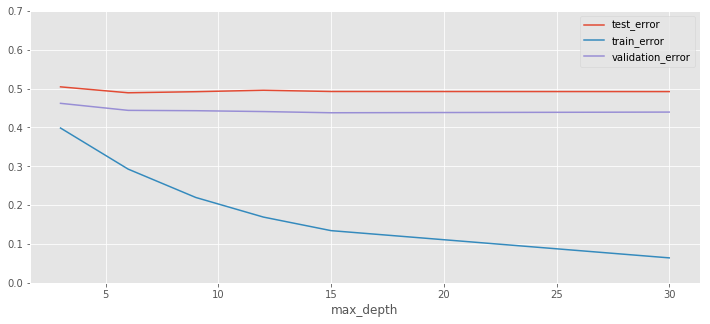

In [33]:
df_max_depth.plot(ylim=(0,0.7), figsize=(12,5))

# And how does learning speed affects the whole process?

In [34]:
results = []

for learning_rate in [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    clf = xgb.XGBClassifier(learning_rate=learning_rate)
    clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': 1 - accuracy_score(y_train, clf.predict(X_train)),
            'validation_error': 1 - accuracy_score(y_val, clf.predict(X_val)),
            'test_error': 1 - accuracy_score(y_test, clf.predict(X_test))
        }
    )
    

In [35]:
df_learning_rate = pd.DataFrame(results).set_index('learning_rate').sort_index()
df_learning_rate

,test_error,train_error,validation_error
learning_rate,,,
0.05,0.479819,0.322285,0.434379
0.10,0.461365,0.241962,0.411843
0.20,0.456187,0.158436,0.395493
0.40,0.467472,0.077781,0.399470
0.60,0.484466,0.050713,0.412285
0.80,0.492698,0.039222,0.438356
1.00,0.501328,0.032925,0.443217


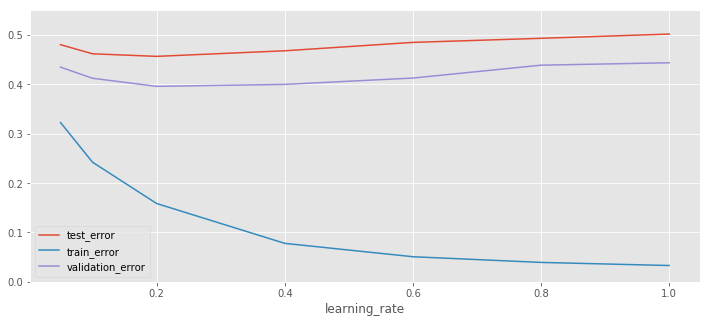

In [36]:
df_learning_rate.plot(ylim=(0,0.55), figsize=(12,5))

# Random subsampling parameters
- subsample (subsample ratio of the training instance)
- colsample_bytree (subsample ratio of columns when constructing each tree
- colsample_bylevel (as above, but per level of the tree rather than whole tree)

# subsample

In [37]:
subsample_search_grid = np.arange(0.2, 1.01, 0.2)
results = []

for subsample in subsample_search_grid:
    clf = xgb.XGBClassifier(subsample=subsample, learning_rate=1.0)
    clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    results.append(
        {
            'subsample': subsample,
            'train_error': 1 - accuracy_score(y_train, clf.predict(X_train)),
            'validation_error': 1 - accuracy_score(y_val, clf.predict(X_val)),
            'test_error': 1 - accuracy_score(y_test, clf.predict(X_test))
        }
    )
    

In [38]:
df_subsample = pd.DataFrame(results).set_index('subsample').sort_index()
df_subsample

,test_error,train_error,validation_error
subsample,,,
0.2,0.649628,0.273009,0.587715
0.4,0.550186,0.050271,0.488290
0.6,0.520579,0.035024,0.463102
0.8,0.517791,0.033256,0.459125
1.0,0.501328,0.032925,0.443217


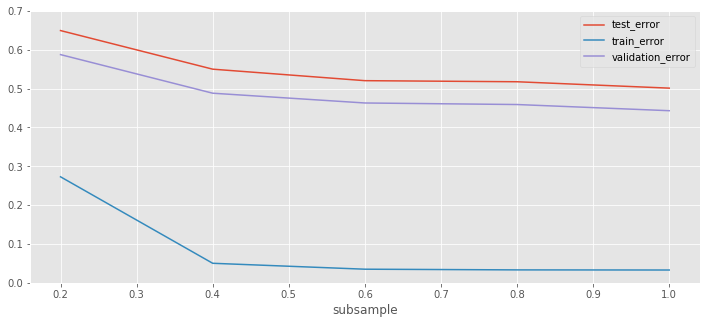

In [48]:
df_subsample.plot(ylim=(0,0.7), figsize=(12,5))

# colsample_bytree

In [40]:
colsample_bytree_search_grid = np.arange(0.2, 1.01, 0.2)
results = []

for colsample_bytree in colsample_bytree_search_grid:
    clf = xgb.XGBClassifier(colsample_bytree=colsample_bytree, learning_rate=1.0)
    clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    results.append(
        {
            'colsample_bytree': colsample_bytree,
            'train_error': 1 - accuracy_score(y_train, clf.predict(X_train)),
            'validation_error': 1 - accuracy_score(y_val, clf.predict(X_val)),
            'test_error': 1 - accuracy_score(y_test, clf.predict(X_test))
        }
    )
    

In [41]:
df_colsample_bytree = pd.DataFrame(results).set_index('colsample_bytree').sort_index()
df_colsample_bytree

,test_error,train_error,validation_error
colsample_bytree,,,
0.2,0.503717,0.036018,0.439240
0.4,0.508763,0.035687,0.440566
0.6,0.500000,0.034361,0.451613
0.8,0.499203,0.032041,0.453380
1.0,0.501328,0.032925,0.443217


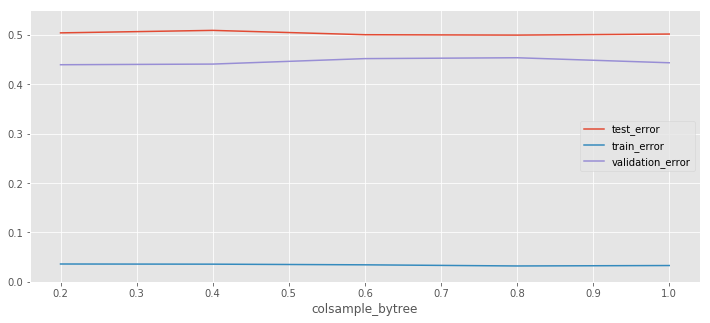

In [42]:
df_colsample_bytree.plot(ylim=(0,0.55), figsize=(12,5))

# colsample_bylevel

In [43]:
colsample_bylevel_search_grid = np.arange(0.2, 1.01, 0.2)
results = []

for colsample_bylevel in colsample_bylevel_search_grid:
    clf = xgb.XGBClassifier(colsample_bylevel=colsample_bylevel, learning_rate=1.0)
    clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    results.append(
        {
            'colsample_bylevel': colsample_bylevel,
            'train_error': 1 - accuracy_score(y_train, clf.predict(X_train)),
            'validation_error': 1 - accuracy_score(y_val, clf.predict(X_val)),
            'test_error': 1 - accuracy_score(y_test, clf.predict(X_test))
        }
    )
    

In [44]:
df_colsample_bylevel = pd.DataFrame(results).set_index('colsample_bylevel').sort_index()
df_colsample_bylevel

,test_error,train_error,validation_error
colsample_bylevel,,,
0.2,0.503585,0.035134,0.436589
0.4,0.499336,0.033808,0.444985
0.6,0.497876,0.034582,0.439240
0.8,0.505975,0.032593,0.459567
1.0,0.501328,0.032925,0.443217


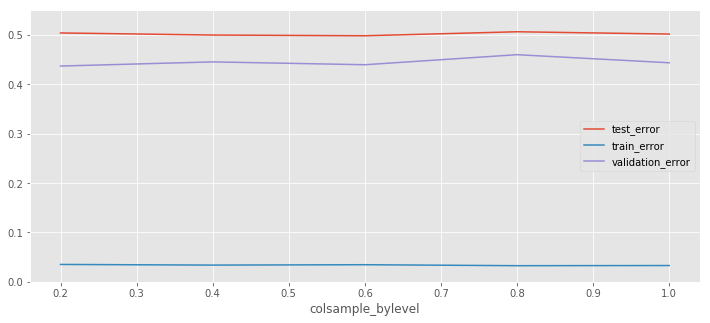

In [45]:
df_colsample_bylevel.plot(ylim=(0,0.55), figsize=(12,5))

# XGBoost objective regularization

![Color](img/regularization.png)
![Color](img/l2_norm.png)

# Regularization parameters

- reg_alpha (L1 regularization, L1 norm factor)
- reg_lambda (L2 regularization, L2 norm factor)
- gamma ("L0 regularization" - dependent on number of leaves)
- min_child_weight - minimum sum o hessians in a child, for RMSE regression it is simply number of examples

- min_child_weight for binary classification would be a sum of second order gradients caluclated by formula:
```cpp
std::max(predt * (1.0f - predt), eps)
```

# Difference between min_child_weight and gamma

- min_child_weight is like a local optimization, there is certain path of the tree that leads to certain number of instances with certain weights there
- gamma is global, it takes into account number of all leaves in a tree

![Color](img/tree_example.png)

# How to tune regularization parameters

- min_child_weight you can just set as sensible value
- alfa, lambda and gamma though depend very much on your other parameters
- different values will be optimal for tree depth 6, and totally different for tree depth 15, as number and weights of leaves will differ a lot

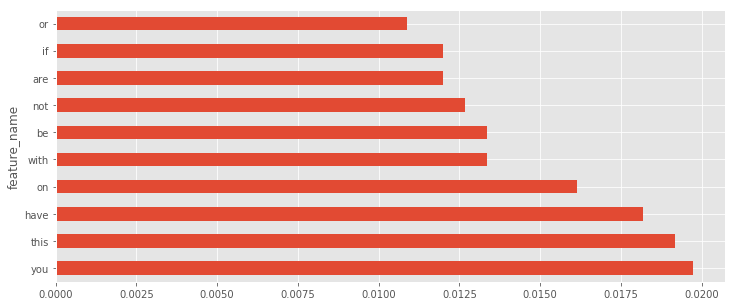

In [69]:
# tf was our TfIdfVectorizer
# clf is our trained xgboost
type(clf.feature_importances_)
df = pd.DataFrame([tf.get_feature_names(), list(clf.feature_importances_)]).T
df.columns = ['feature_name', 'feature_score']
df.sort_values('feature_score', ascending=False, inplace=True)
df.set_index('feature_name', inplace=True)
df.iloc[:10].plot(kind='barh', legend=False, figsize=(12,5))

# Lessons learned from feature analysis

- as you see most of the features look like stopwords
- they can actually correspond to post length and some writing style of contributors
- as general practice says, and winners of many Kaggle competitions agree on:
    - feature enegineering is extremely important
    - aim to maintain your code in such manner, that at least initially you can analyse the features
    - there are some dedicated packages for analysis of feature importance for "black box" models (eli5)
    - and also xgboost has a possibility of more sophisticated feature analysis, could be in repo version only though

# Some things not mentioned elsewhere

- in regression problems, tree version of XGBoost cannot extrapolate
- current documentation is not compatibile with Python package (which is quite outdated)
- there are some histogram based improvements, similar like in LightGBM, to train the models faster (a lot of issues were reported about this feature)
- in 0.6a2 version from pip repo, there is a bug in handling csr matrices

# Links

- https://github.com/datitran/jupyter2slides

- https://github.com/dmlc/xgboost

- https://arxiv.org/pdf/1603.02754.pdf